In [1]:
import os
import argparse
import math
import numpy as np
import imageio
import scipy.io
import glob
import cv2
import matplotlib.pyplot as plt
import time
from read_xgaze import read_xml,read_csv_as_dict, read_lm_gc
from normalize_data import read_image, normalize, estimateHeadPose
from utils import vector_to_pitchyaw, add
from PIL import Image

In [2]:
from utils import convert_img

In [3]:
from stable_diffusion_utils import DepthToImage

In [3]:
generator = DepthToImage()

No module 'xformers'. Proceeding without it.
LatentDepth2ImageDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [6]:
image = Image.open('cam00.JPG')

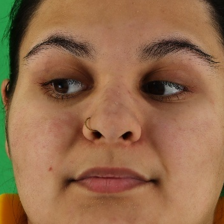

In [9]:
convert_img(image,
            old_roi=512,
            old_focal=750,
            old_distance= 300,
            new_roi = 224,
            new_focal = 960,
            new_distance= 600)

Global seed set to 500


loaded input image of size (512, 512)
resized input image to size (512, 512 (w, h))
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.6223853

Decoding image: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.10it/s]


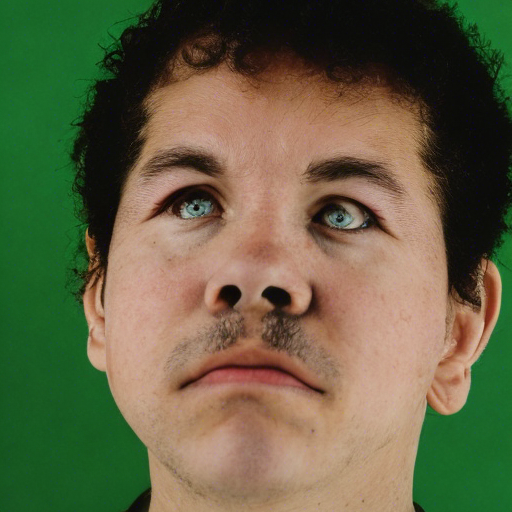

In [42]:
generator.generate_image(image, prompt = "photo of a person's face", seed=500, scale=9, steps=50, strength=0.6)

In [ ]:
# Normalization parameters

focal_norm = 960 # focal length of normalized camera
distance_norm = 600 # normalized distance between eye and camera
roi_size = (224, 224) # size of cropped eye image

In [ ]:
focal_norm = 960 # focal length of normalized camera
distance_norm = 300 # normalized distance between eye and camera
roi_size = (448, 448) # size of cropped eye image

In [ ]:
focal_norm = 960 # focal length of normalized camera
distance_norm = 200 # normalized distance between eye and camera
roi_size = (448, 448) # size of cropped eye image

In [9]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [10]:
def get_distance_norm_from(roi_size):
    constant_ratio = 600*224 # this needs to stay constant.
    return constant_ratio/roi_size

In [11]:
def make_divisors(n):
    lower_divisors , upper_divisors = [], []
    i = 1
    while i*i <= n:
        if n % i == 0:
            lower_divisors.append(i)
            if i != n // i:
                upper_divisors.append(n//i)
        i += 1
    return lower_divisors + upper_divisors[::-1]

In [12]:
import pprint
print(make_divisors(600*224))

[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 20, 21, 24, 25, 28, 30, 32, 35, 40, 42, 48, 50, 56, 60, 64, 70, 75, 80, 84, 96, 100, 105, 112, 120, 128, 140, 150, 160, 168, 175, 192, 200, 210, 224, 240, 256, 280, 300, 320, 336, 350, 384, 400, 420, 448, 480, 525, 560, 600, 640, 672, 700, 768, 800, 840, 896, 960, 1050, 1120, 1200, 1280, 1344, 1400, 1600, 1680, 1792, 1920, 2100, 2240, 2400, 2688, 2800, 3200, 3360, 3840, 4200, 4480, 4800, 5376, 5600, 6400, 6720, 8400, 8960, 9600, 11200, 13440, 16800, 19200, 22400, 26880, 33600, 44800, 67200, 134400]


In [13]:
roi_size = 480
distance_norm = get_distance_norm_from(roi_size)
distance_norm

280.0

In [14]:
for_depth_roi_size = int(roi_size*1.5)
for_depth_roi_size = for_depth_roi_size - (for_depth_roi_size % 64)
assert for_depth_roi_size % 64 == 0
for_depth_roi_size

704

In [15]:
roi_size = (roi_size, roi_size)
for_depth_roi_size = (for_depth_roi_size, for_depth_roi_size)

In [16]:
for_depth_roi_size

(704, 704)

In [12]:
def lm68_to_50(lm_68):
	'''
	lm_68: (68,2)
	'''
	lm_50 = np.zeros((50,2))
	lm_50[0] = lm_68[8]
	lm_50[1:44] = lm_68[17:60]
	lm_50[44:47] = lm_68[61:64]
	lm_50[47:50] = lm_68[65:68]
	return lm_50

In [13]:
def get_normalized(roi_size, distance_norm, focal_norm=960):
    base_dir = '/home/s-uesaka/datasets/xgazeraw'
    raw_path = os.path.join(base_dir, 'data/train') 
    calibration_path = os.path.join(base_dir, 'calibration/cam_calibration') 
    annatation_path = os.path.join(base_dir, 'data/annotation_train')  

    input_path='/home/s-uesaka/datasets/xgazeraw/data/train/subject0000/frame0001/cam00.JPG'
    img_name = os.path.basename(input_path)
    frame = input_path.split('/')[-2]
    subject = input_path.split('/')[-3]
    csv_path = os.path.join(annatation_path, subject+'.csv') 


    sub_dict = read_csv_as_dict(csv_path)


    camera_path = os.path.join(calibration_path , img_name.replace('.JPG','.xml'))
    camera_matrix, camera_distortion, camera_translation, camera_rotation = read_xml(camera_path)

    img_path = os.path.join(raw_path, subject, frame, img_name)
    print(img_path)
    img = read_image(img_path, camera_matrix, camera_distortion)
    lm_gt, gc, _, _ = read_lm_gc(sub_dict, os.path.join(frame,img_name))

    # #  Data Normalization
    # # --------------------------------------------  estimate head pose --------------------------------------------
    face_model_load = np.loadtxt('./face_model.txt')
    use_68 = True 
    '''
    Use 50 landmarks to estimate head pose, or only use 6 landmarks
    '''
    if use_68:
        landmarks_sub = lm68_to_50(lm_gt) 
        landmarks_sub = landmarks_sub.astype(float)  # input to solvePnP function must be float type
        landmarks_sub = landmarks_sub.reshape(50, 1, 2)  # input to solvePnP requires such shape
        facePts = face_model_load.reshape(50, 1, 3)
        hr, ht = estimateHeadPose(landmarks_sub, facePts, camera_matrix, camera_distortion, iterate=True)
    else:
        face_model = face_model_load[[20, 23, 26, 29, 15, 19], :]  # the eye and nose landmarks
        facePts = face_model.reshape(6, 1, 3)
        landmarks_sub = lm_gt[[36, 39, 42, 45, 31, 35], :]
        landmarks_sub = landmarks_sub.astype(float)  # input to solvePnP function must be float type
        landmarks_sub = landmarks_sub.reshape(6, 1, 2)  # input to solvePnP requires such shape
        hr, ht = estimateHeadPose(landmarks_sub, facePts, camera_matrix, camera_distortion, iterate=True)

    # compute estimated 3D positions of the landmarks
    ht = ht.reshape((3,1))
    hR = cv2.Rodrigues(hr)[0] # rotation matrix
    face_model = face_model_load[[20, 23, 26, 29, 15, 19], :]  # the eye and nose landmarks
    Fc = np.dot(hR, face_model.T) + ht # 3D positions of facial landmarks
    # get the face center
    two_eye_center = np.mean(Fc[:, 0:4], axis=1).reshape((3, 1))
    nose_center = np.mean(Fc[:, 4:6], axis=1).reshape((3, 1))
    face_center = np.mean(np.concatenate((two_eye_center, nose_center), axis=1), axis=1).reshape((3, 1))

    # -------------------------------------------- normalize image --------------------------------------------
    img_face, R, hR_norm, gaze_norm, landmarks_norm = normalize(img,lm_gt, focal_norm, distance_norm, roi_size, face_center, hr, ht, camera_matrix, gc)
    img_face = img_face[:,:,::-1]
    return Image.fromarray(img_face)

/home/s-uesaka/datasets/xgazeraw/data/train/subject0000/frame0001/cam00.JPG


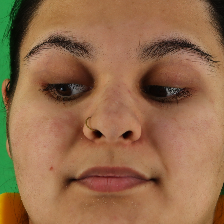

In [14]:
get_normalized(roi_size=(224,224), distance_norm=600, focal_norm=960)


/home/s-uesaka/datasets/xgazeraw/data/train/subject0000/frame0001/cam05.JPG


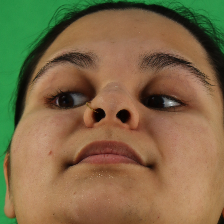

In [26]:
get_normalized(roi_size=(224,224), distance_norm=300, focal_norm=480)

In [22]:
print('hi')

hi


In [ ]:
from normalize_xgaze import generate_normalized_xgaze

In [ ]:
image, _, _,_, = generate_normalized_xgaze("/home/s-uesaka/datasets/xgazeraw/data/train/subject0000/frame0001/cam05.JPG",
                                           roi_size=(224,224),
                                           distance_norm=600,
                                          calibration_path = '/home/s-uesaka/datasets/xgazeraw/calibration/cam_calibration',
                                            annotation_path = '/home/s-uesaka/datasets/xgazeraw/data/annotation_train')

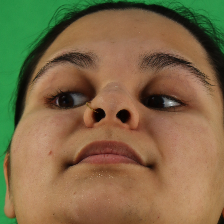

In [201]:
Image.fromarray(image[:,:,::-1])

/home/s-uesaka/datasets/xgazeraw/data/train/subject0000/frame0001/cam05.JPG


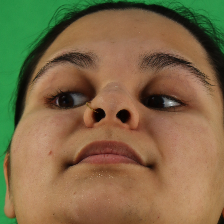

In [193]:
get_normalized(roi_size=(224,224), distance_norm=600)

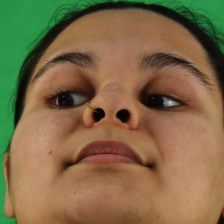

In [186]:
Image.fromarray(cv2.resize(np.array(get_normalized(roi_size=(448,448), distance_norm=300)), (224,224), interpolation=cv2.INTER_AREA))

(704, 704)


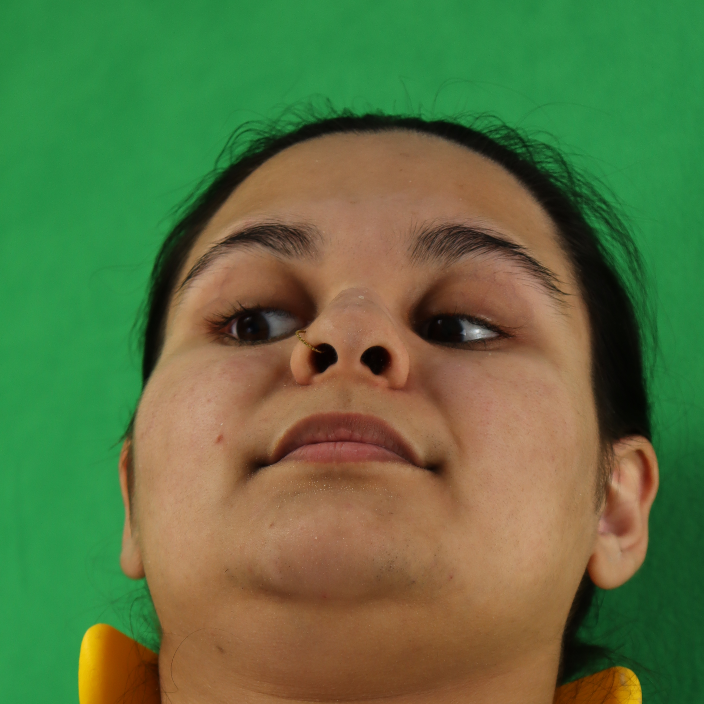

In [187]:
from PIL import Image, ImageDraw
image_face = get_normalized(for_depth_roi_size, distance_norm)
print(image_face.size)
image_face

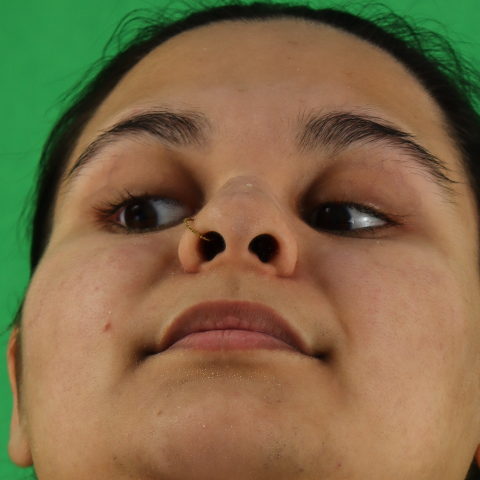

In [188]:
crop_center(image_face, roi_size[0], roi_size[1])

In [189]:
generated_image = generator.generate_image(image_face, prompt = "photo of a person's face", seed=0, scale=9, steps=50, strength=0.6)

Global seed set to 0


loaded input image of size (704, 704)
resized input image to size (704, 704 (w, h))
Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.6223853

Decoding image: 100%|███████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.45it/s]


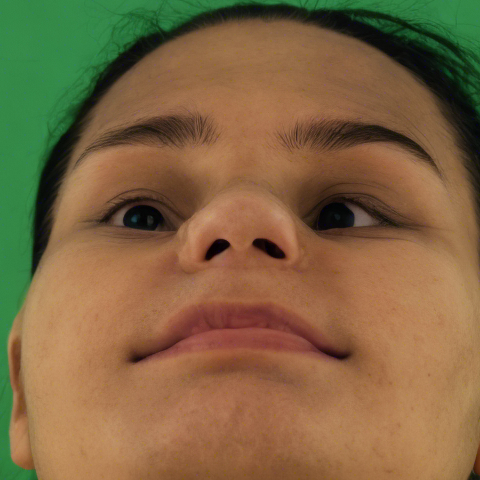

In [190]:
crop_center(generated_image, roi_size[0], roi_size[1])

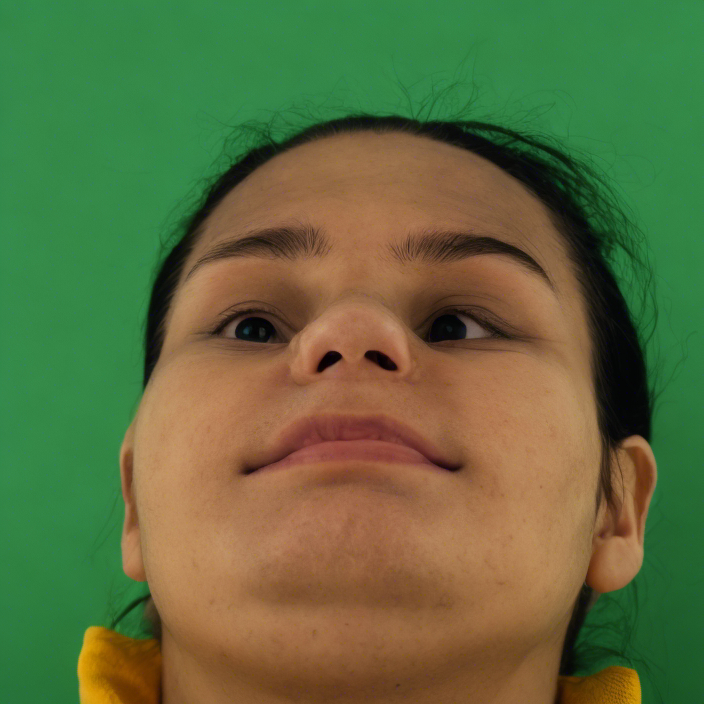

In [191]:
generated_image

In [1]:
from augment_sample import SampleGenerator

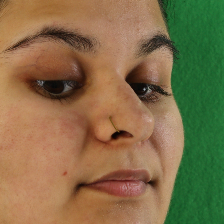

In [4]:
SampleGenerator.generate_not_augmented(image_path="/home/s-uesaka/datasets/xgazeraw/data/train/subject0000/frame0001/cam02.JPG")

In [7]:
generator = SampleGenerator()

No module 'xformers'. Proceeding without it.
LatentDepth2ImageDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 31.75 GiB total capacity; 1.10 GiB already allocated; 8.50 MiB free; 1.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
result, intermediate_results = generator.generate_augmentated_image(
    image_path="/home/s-uesaka/datasets/xgazeraw/data/train/subject0000/frame0001/cam03.JPG"
)

In [ ]:
result

In [30]:
intermediate_results

{'normalized': <PIL.Image.Image image mode=RGB size=704x704>,
 'depth': <PIL.Image.Image image mode=RGB size=704x704>,
 'inpainted': <PIL.Image.Image image mode=RGB size=704x704>,
 'cropped': <PIL.Image.Image image mode=RGB size=480x480>}

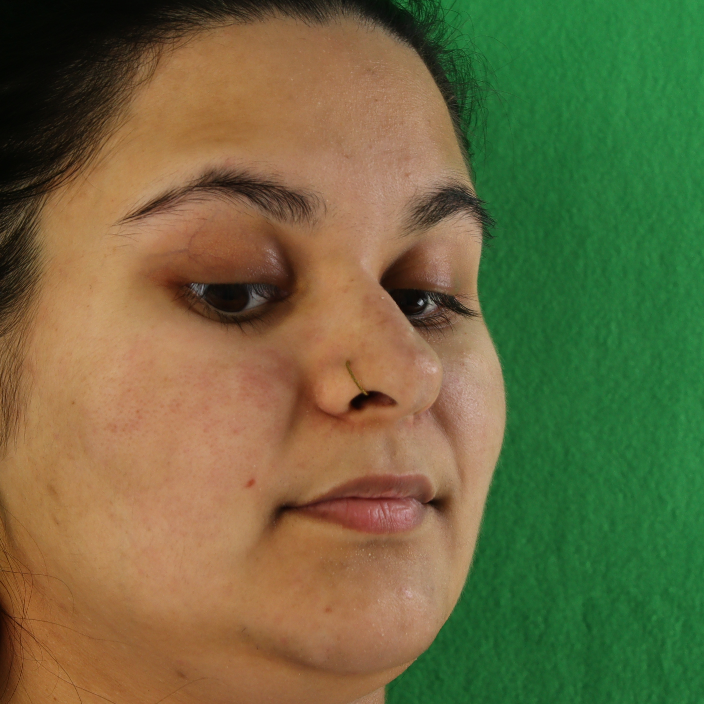

In [31]:
intermediate_results['normalized']

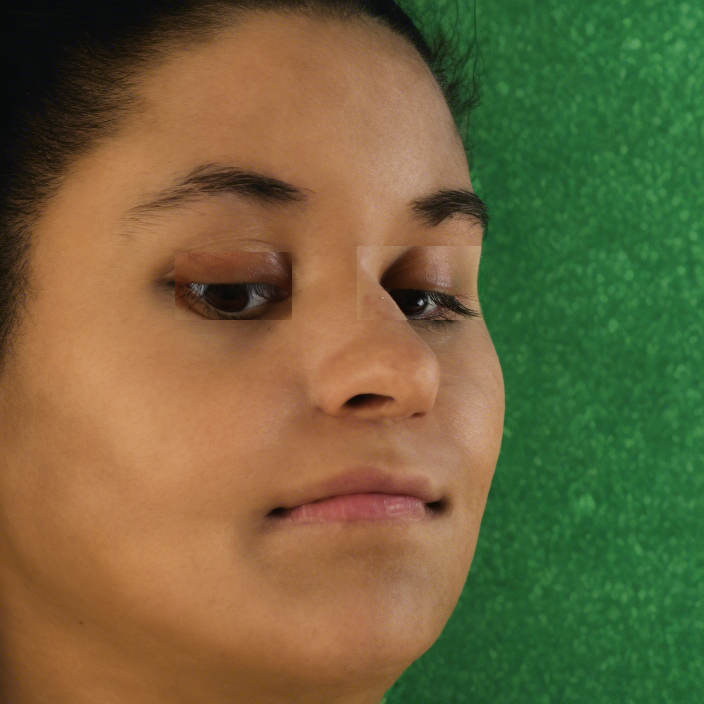

In [32]:
intermediate_results['depth']

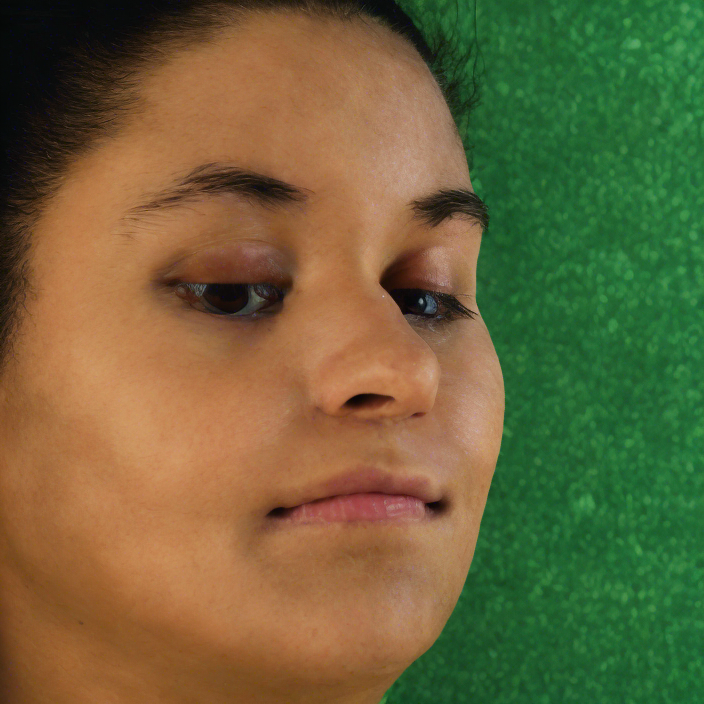

In [33]:
intermediate_results['inpainted']

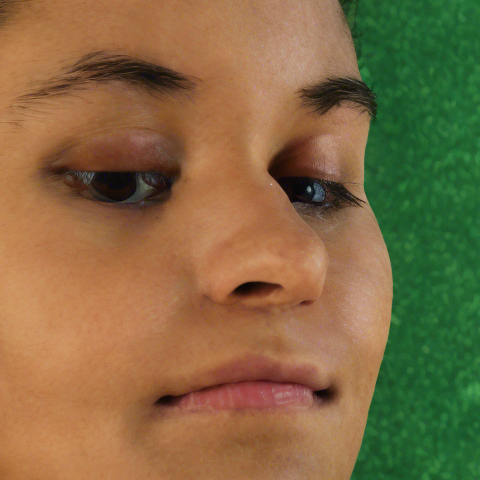

In [34]:
intermediate_results['cropped']

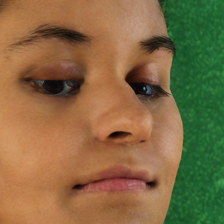

In [35]:
result